In [7]:
import torch
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm

### MNIST

In [ ]:
transform = transforms.Compose( [transforms.ToTensor()] )

In [ ]:
mnist_data = torchvision.datasets.MNIST( download = True, train = True, transform=transform, root = './' )

In [ ]:
train = Subset(mnist_data, torch.arange(10000))
valid = Subset(mnist_data, torch.arange(10000,len(mnist_data)))

In [ ]:
mnist_test = torchvision.datasets.MNIST( root = './', train = False, download = True, transform = transform)

In [ ]:
torch.manual_seed(0)
dl_train = DataLoader(train, batch_size=32, shuffle = True)
dl_valid = DataLoader(valid, batch_size=32, shuffle = False)

In [ ]:
model = nn.Sequential()

model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels  = 1,
        out_channels = 32,
        kernel_size  = 5,
        padding = 2
    )
)

model.add_module(
    'ReLU',
    nn.ReLU()
)

model.add_module(
    'Pool',
    nn.MaxPool2d(kernel_size = 2)
)

model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels  = 32,
        out_channels = 64,
        kernel_size  = 5,
        padding = 2
    )
)

model.add_module(
    'ReLU2',
    nn.ReLU()
)

model.add_module(
    'Pool2',
    nn.MaxPool2d(
        kernel_size=2
    )
)

In [ ]:
model

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot, make_dot_from_trace

In [ ]:
x = torch.ones(( 4, 1, 28, 28 ))

make_dot(model(x), params=dict(model.named_parameters()))

In [ ]:
model.add_module( 'flatten', nn.Flatten() )
model(x).shape

In [ ]:
model.add_module( 'linear', nn.Linear(3136, 1024) )
model.add_module( 'ReLU3',  nn.ReLU()   )
model.add_module( 'dropout',  nn.Dropout(p=0.5)   )
model.add_module( 'linear2', nn.Linear(1024, 10) )

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim   = torch.optim.Adam( model.parameters(), lr = 0.001 )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
model.to(device)

In [ ]:
def train( model, n_epochs, dl_train, dl_valid ):
  train_acc_hist  = [0] * n_epochs
  trin_loss_hist  = [0] * n_epochs
  valid_acc_hist  = [0] * n_epochs
  valid_loss_hist = [0] * n_epochs
  for e in tqdm(range(n_epochs)):
    train_acc_hist[e] = 0
    trin_loss_hist[e] = 0
    valid_acc_hist[e] = 0
    valid_loss_hist[e] = 0
    for x_batch, y_batch in dl_train:
      pred = model(x_batch)
      cost = loss_fn(pred, y_batch)
      optim.zero_grad()
      cost.backward()
      optim.step()
      trin_loss_hist[e] += cost.item() * y_batch.size(0)
      train_acc_hist[e] += ( torch.argmax( pred, dim = 1 ) == y_batch ).float().sum().mean()

    trin_loss_hist[e] /= len(dl_train.dataset)
    train_acc_hist[e] /= len(dl_train.dataset)

    model.eval()

    with torch.no_grad():
      for x_batch, y_batch in dl_valid:
        pred = model(x_batch)
        cost = loss_fn(pred, y_batch)
        valid_loss_hist[e] += cost.item() * y_batch.size(0)
        valid_acc_hist[e]  += (torch.argmax( pred, dim = 1 ) == y_batch).float().sum().mean()
      valid_loss_hist[e] /= len(dl_train.dataset)
      valid_acc_hist[e] /= len(dl_train.dataset)

      print(f'Val Loss:{valid_loss_hist[e]}, Val Acc:{valid_acc_hist[e]}')
      print(f'Train Loss:{trin_loss_hist[e]}, Train Acc:{train_acc_hist[e]}')

      return ( valid_loss_hist[e], valid_acc_hist[e], trin_loss_hist[e], train_acc_hist[e] )

In [ ]:
n_epochs = 20
hist = train(model, n_epochs, dl_train, dl_valid)

### CelabA

In [ ]:
!pip install gdown

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing

In [ ]:
!unzip /content/celeba.zip

In [ ]:
!unzip /content/celeba/img_align_celeba.zip

In [8]:
image_path = "./"
celeb_train = torchvision.datasets.CelebA( split = 'train', root = image_path, target_type='attr', download = False )
celeb_valid = torchvision.datasets.CelebA( split = 'valid', root = image_path, target_type='attr', download = False )
celeb_test = torchvision.datasets.CelebA( split = 'test', root = image_path, target_type='attr', download = False )

In [9]:
print("Train len :", len(celeb_train))
print("Valid len :", len(celeb_valid))
print("Test  len :", len(celeb_test))

Train len : 162770
Valid len : 19867
Test  len : 19962


In [10]:
import matplotlib.pyplot as plt

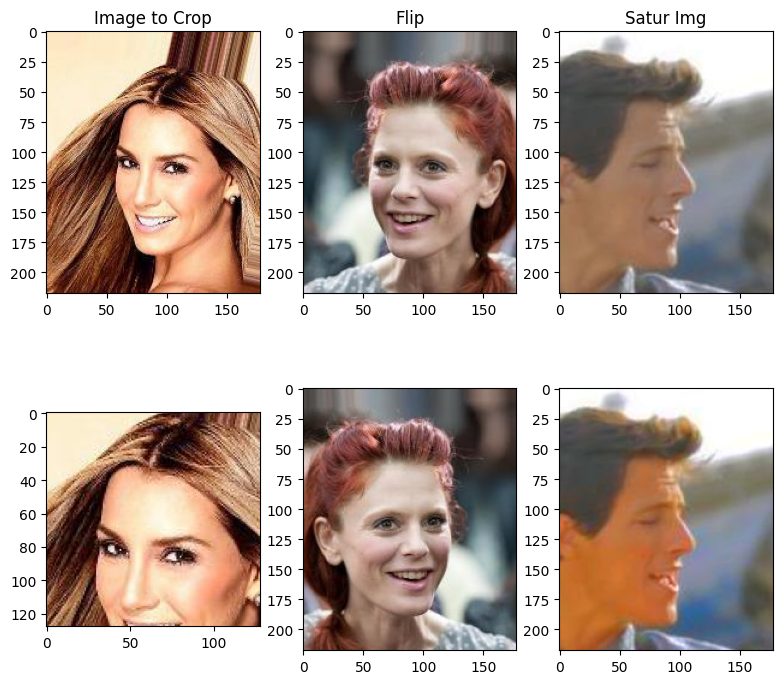

In [11]:
fig = plt.figure( figsize = (16, 8.5) )
img, attr = celeb_train[0]
ax = fig.add_subplot( 2, 5, 1 )
ax.set_title("Image to Crop")
ax.imshow(img)
ax = fig.add_subplot( 2, 5, 6 )
cropped_img = transforms.functional.crop(img,28,28,128,128)
ax.imshow(cropped_img)

img, attr = celeb_train[1]
ax = fig.add_subplot( 2, 5, 2 )
ax.set_title("Flip")
ax.imshow(img)
ax = fig.add_subplot( 2, 5, 7 )
flipped_img = transforms.functional.hflip(img)
ax.imshow(flipped_img)

img, attr = celeb_train[2]
ax = fig.add_subplot(2,5,3)
ax.set_title("Satur Img")
ax.imshow(img)
ax = fig.add_subplot(2,5,8)
saturated_img  = transforms.functional.adjust_saturation(img,2)
ax.imshow(saturated_img)

plt.show()

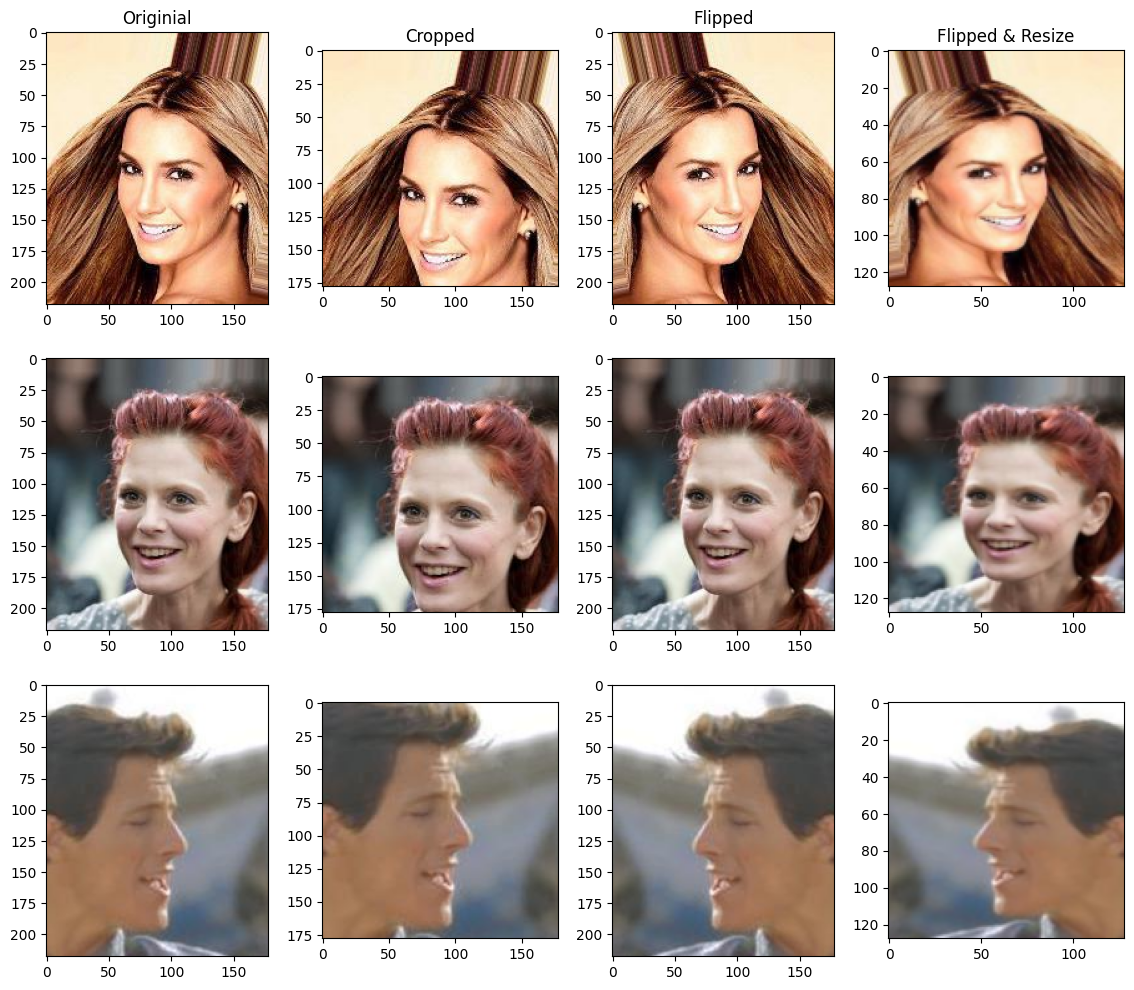

In [16]:
torch.manual_seed(0)
fig = plt.figure( figsize=(14, 12) )
for i,(img, attr) in enumerate(celeb_train):

  ax = fig.add_subplot(3,4,i*4+1)
  ax.imshow(img)
  if( i == 0):
    ax.set_title("Originial")

  ax = fig.add_subplot(3,4,i*4+2)
  img_transform = transforms.Compose( [transforms.RandomCrop([178,178])] )
  crop_img = img_transform(img)
  ax.imshow(crop_img)
  if( i == 0):
    ax.set_title("Cropped")

  ax = fig.add_subplot(3,4,i*4+3)
  img_transform = transforms.Compose( [transforms.RandomHorizontalFlip()] )
  flipped_img = img_transform(img)
  ax.imshow(flipped_img)
  if( i == 0):
    ax.set_title("Flipped")

  ax = fig.add_subplot(3,4,i*4+4)
  img_resize = transforms.functional.resize( flipped_img, size = (128, 128) )
  ax.imshow(img_resize)
  if( i == 0 ):
    ax.set_title("Flipped & Resize")

  if( i == 2 ):
    break


In [18]:
get_smile = lambda attr: attr[18]

In [63]:
transform_train = transforms.Compose( [ transforms.RandomHorizontalFlip(), transforms.RandomCrop([120,120]), transforms.Resize(size=(64,64)), transforms.ToTensor() ] )
transform_test = transforms.Compose( [ transforms.RandomCrop([120,120]), transforms.Resize(size=(64,64)), transforms.ToTensor() ] )

In [64]:
from torch.utils.data import DataLoader

In [65]:
data_train = torchvision.datasets.CelebA( root = image_path, transform=transform_train, download = False, split = "train", target_transform=get_smile, target_type="attr" )

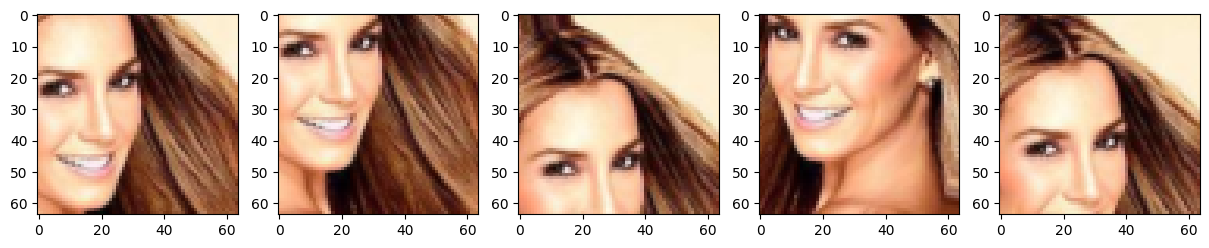

In [66]:
torch.manual_seed(0)
train_dl = DataLoader( data_train, batch_size = 2 )
fig = plt.figure( figsize = ( 15, 6 ) )
n_epochs = 5
for i in range(n_epochs):
  img_batch, attr_batch = next(iter(train_dl))
  img = img_batch[0]
  ax = fig.add_subplot(2,5,i+1)
  ax.imshow(img.permute(1,2,0))

In [67]:
data_test = torchvision.datasets.CelebA( root = image_path, transform=transform_test, download = False, split = "test", target_transform=get_smile, target_type="attr" )
data_valid = torchvision.datasets.CelebA( root = image_path, transform=transform_test, download = False, split = "valid", target_transform=get_smile, target_type="attr" )

In [68]:
from torch.utils.data import Subset

In [69]:
train_sample = Subset( data_train, torch.arange(16000) )
valid_sample = Subset( data_valid, torch.arange(1000) )

In [70]:
train_dl = DataLoader( train_sample, batch_size = 32, shuffle = True )
test_dl = DataLoader( data_test, batch_size = 32, shuffle = False )
valid_dl = DataLoader( valid_sample, batch_size = 32, shuffle = False)

In [71]:
model = nn.Sequential()

model.add_module(
    'conv1',
    nn.Conv2d( 3, 32, 3, padding = 1 )
 )

model.add_module(
    'ReLU',
    nn.ReLU()
)

model.add_module(
    'pooling',
    nn.MaxPool2d(2)
)

model.add_module(
    'dropout',
    nn.Dropout(p=0.5)
)

In [59]:
model.add_module(
    'conv2',
    nn.Conv2d( 32, 64, 3, padding = 1 )
 )

model.add_module(
    'ReLU',
    nn.ReLU()
)

model.add_module(
    'pooling',
    nn.MaxPool2d(2)
)

model.add_module(
    'dropout',
    nn.Dropout(p=0.5)
)

In [60]:
model.add_module(
    'conv3',
    nn.Conv2d( 64, 128, 3, padding = 1 )
 )

model.add_module(
    'ReLU',
    nn.ReLU()
)

model.add_module(
    'pooling',
    nn.MaxPool2d(2)
)

model.add_module(
    'dropout',
    nn.Dropout(p=0.5)
)

In [61]:
model.add_module(
    'conv3',
    nn.Conv2d( 128, 256, 3, padding = 1 )
 )

model.add_module(
    'ReLU',
    nn.ReLU()
)

model.add_module(
    'pool',
    nn.AvgPool2d
)

In [74]:
x = torch.ones(4,3,64,64)
model(x).size()

torch.Size([4, 32, 32, 32])

In [83]:
import torch.nn as nn

model2 = nn.Sequential()

model2.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model2.add_module('relu1', nn.ReLU())
model2.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model2.add_module('dropout1', nn.Dropout(p=0.5))

model2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model2.add_module('relu2', nn.ReLU())
model2.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model2.add_module('dropout2', nn.Dropout(p=0.5))

model2.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model2.add_module('relu3', nn.ReLU())
model2.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model2.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model2.add_module('relu4', nn.ReLU())

In [84]:
model2(x).size()

torch.Size([4, 256, 8, 8])

In [85]:
model2.add_module( 'pool4', nn.AvgPool2d(8) )

In [87]:
model2(x).squeeze().size()

torch.Size([4, 256])

In [88]:
model2.add_module( 'flatten', nn.Flatten() )

In [90]:
model2(x).size()

torch.Size([4, 256])

In [91]:
model2.add_module( 'fc', nn.Linear(256,1))
model2.add_module( 'activation', nn.Sigmoid())

In [92]:
model2(x).size()

torch.Size([4, 1])

In [93]:
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(params = model2.parameters(), lr = 0.001)

In [94]:
from tqdm import tqdm

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model2.to(device)

In [ ]:
def train( model, n_epochs, train_dl, valid_dl ):
  for e in tqdm(range(n_epochs)):

    loss_hist_train  = [0] * n_epochs
    acc_hist_train   = [0] * n_epochs
    loss_hist_valid  = [0] * n_epochs
    acc_hist_valid   = [0] * n_epochs

    for x_batch, y_batch in train_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      pred = model(x_batch).squeeze()
      cost = loss_fn(pred.float(), y_batch.float())
      optim.zero_grad()
      cost.backward()
      optim.step()
      loss_hist_train[e] += cost.item() * y_batch.size(0)
      acc_hist_train[e]  += (( pred >= 0.5 ).float() == y_batch).float().sum()

    loss_hist_train[e] /= len(train_dl)
    acc_hist_train[e] /= len(train_dl)
    print(f"Epoch: {e}, Loss: {loss_hist_train[e]}")

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch).squeeze()
        cost = loss_fn(pred.float(), y_batch.float())
        optim.zero_grad()
        cost.backward()
        optim.step()
        loss_hist_valid[e] += cost.item() * y_batch.size(0)
        acc_hist_valid[e]  += (( pred >= 0.5 ).float() == y_batch).float().sum()

    return ( loss_hist_train, acc_hist_train, loss_hist_valid, loss_hist_train )

torch.manual_seed(0)
n_epochs = 30
hist = train(model2, n_epochs, train_dl, valid_dl)